In [0]:
import tensorflow as tf
keras, L = tf.keras, tf.keras.layers

import matplotlib.pyplot as plt
import numpy as np

from skimage.transform import resize
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [1]:
!pip3 install tensorflow-gpu==2.0.0

In [0]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

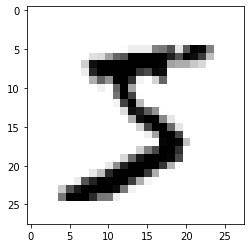

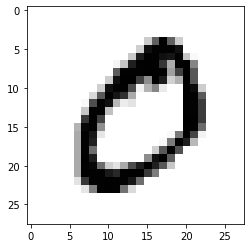

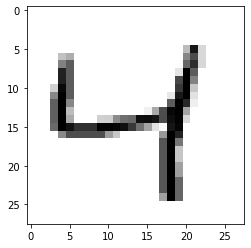

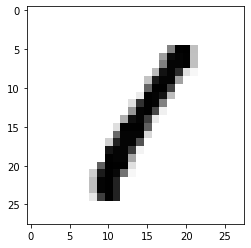

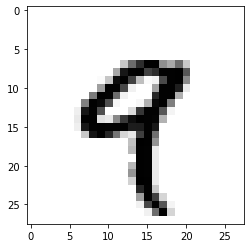

In [4]:
for i in range(5):
    plt.imshow(np.reshape(X[i], (28, 28)), cmap=plt.cm.gray_r)
    plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
del X, y

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28))
X_train = np.stack([X_train]*3, axis=-1)
y_train = y_train.astype(int)

X_test = np.reshape(X_test, (X_test.shape[0], 28, 28))
X_test = np.stack([X_test]*3, axis=-1)
y_test = y_test.astype(int)

In [0]:
def init_block(x, filters):
    x = L.Conv2D(filters=filters, kernel_size=1, 
                 input_shape=input_shape, padding="SAME")(x)
    return x

In [0]:
def f(x, filters):
    x = L.BatchNormalization(axis=3)(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(filters=filters, kernel_size=3, padding="SAME")(x)
    x = L.BatchNormalization(axis=3)(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(filters=filters, kernel_size=3, padding="SAME")(x)
    
    return x

def rev_block(x, filters):
    x1, x2 = tf.split(x, num_or_size_splits=2, axis=3)
    y1 = f(x2, filters // 2) + x1
    y2 = f(y1, filters // 2) + x2

    return tf.concat([y1, y2], axis=3)

**Модель с Reversible блоком, но в конце которой находятся Dense слои:**

In [0]:
input_shape = X_train.shape[1:]
filters = 32
n_rev_blocks = 1
n_classes = 10

def build_model():
    img_input = L.Input(input_shape)
    x = init_block(img_input, filters)
    for _ in range(n_rev_blocks):
        x = rev_block(x, filters)
    x = L.Flatten()(x)

    x = L.Dense(100)(x)
    x = L.Activation("relu")(x)
    x = L.Dense(n_classes)(x)
    x = L.Activation("softmax")(x)

    model = keras.Model(img_input, x)

    return model

In [18]:
model = build_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 28, 28, 32)   128         input_5[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split_4 (TensorFlow [(None, 28, 28, 16), 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 28, 28, 16)   64          tf_op_layer_split_4[0][1]        
____________________________________________________________________________________________

In [0]:
adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52416/52500 [============================>.] - ETA: 0s - loss: 2.3425 - sparse_categorical_accuracy: 0.6589
Epoch 00001: val_loss improved from inf to 0.88950, saving model to revnet_with_dense.hdf5
52500/52500 [==============================] - 13s 243us/sample - loss: 2.3401 - sparse_categorical_accuracy: 0.6591 - val_loss: 0.8895 - val_sparse_categorical_accuracy: 0.7757
Epoch 2/40
52224/52500 [============================>.] - ETA: 0s - loss: 0.6189 - sparse_categorical_accuracy: 0.8334
Epoch 00002: val_loss improved from 0.88950 to 0.40819, saving model to revnet_with_dense.hdf5
52500/52500 [==============================] - 12s 224us/sample - loss: 0.6184 - sparse_categorical_accuracy: 0.8335 - val_loss: 0.4082 - val_sparse_categorical_accuracy: 0.8925
Epoch 3/40
52480/52500 [============================>.] - ETA: 0s - loss: 0.2397 - sparse_categorical_accuracy: 0.9389
Epoch 00003: val_loss improved from 0.40819 to 0.16

**Переобучение сети на маленьком батче:**

In [0]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

earlystopper = keras.callbacks.EarlyStopping(monitor="loss", patience=5, 
                                             verbose=1)

model.fit(X_train[:32], y_train[:32],
          batch_size=32, epochs=40,
          callbacks=[earlystopper])

Train on 32 samples
Epoch 1/40
32/32 [==============================] - 1s 32ms/sample - loss: 52.8831 - sparse_categorical_accuracy: 0.1562
Epoch 2/40
32/32 [==============================] - 0s 441us/sample - loss: 158.0528 - sparse_categorical_accuracy: 0.4688
Epoch 3/40
32/32 [==============================] - 0s 430us/sample - loss: 188.1282 - sparse_categorical_accuracy: 0.5000
Epoch 4/40
32/32 [==============================] - 0s 432us/sample - loss: 128.7907 - sparse_categorical_accuracy: 0.5312
Epoch 5/40
32/32 [==============================] - 0s 352us/sample - loss: 66.2178 - sparse_categorical_accuracy: 0.6562
Epoch 6/40
32/32 [==============================] - 0s 346us/sample - loss: 22.7801 - sparse_categorical_accuracy: 0.7188
Epoch 7/40
32/32 [==============================] - 0s 340us/sample - loss: 5.4840 - sparse_categorical_accuracy: 0.8438
Epoch 8/40
32/32 [==============================] - 0s 383us/sample - loss: 2.0206 - sparse_categorical_accuracy: 0.9375
Epoc

**LR range test** (https://www.kaggle.com/paultimothymooney/learning-rate-finder-for-keras):

In [0]:
import math
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K

In [0]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        loss = logs['loss']
        self.losses.append(loss)

        if math.isnan(loss) or loss > self.best_loss * 1000:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        self.model.save_weights('tmp.h5')

        original_lr = K.get_value(self.model.optimizer.lr)

        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        self.model.load_weights('tmp.h5')

        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, y_lim=(0, 100)):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.figure(figsize=(12, 8))
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        x = self.lrs[n_skip_beginning:-n_skip_end]
        y = self.losses[n_skip_beginning:-n_skip_end]
        plt.plot(x, y)
        plt.xscale('log')
        plt.ylim(y_lim)

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)


Для SGD:

Train on 52500 samples
16384/52500 [========>.....................] - ETA: 4s - loss: 252.6918 - sparse_categorical_accuracy: 0.4140

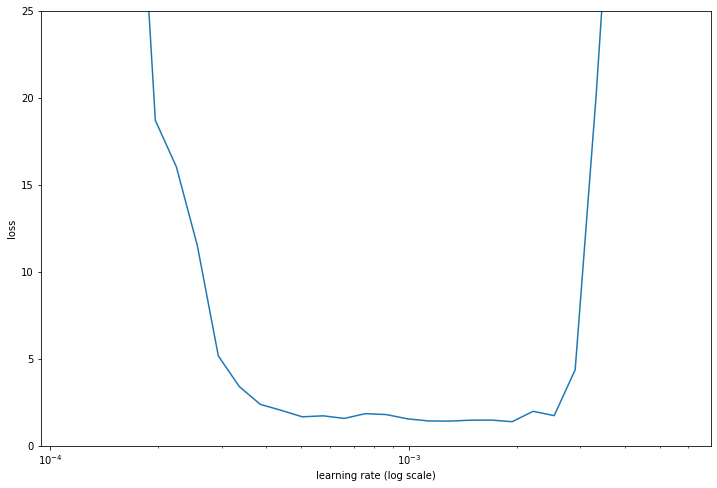

In [0]:
model = build_model()

model.compile(optimizer=keras.optimizers.SGD(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

lr_finder = LRFinder(model)
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=100, batch_size=512, epochs=1)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1, y_lim=(0, 25))
plt.show()

Посмотрим качество обучения для лучших lr:

In [0]:
 model = build_model()
 
 model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_sgd.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52192/52500 [============================>.] - ETA: 0s - loss: 1.1177 - sparse_categorical_accuracy: 0.7969
Epoch 00001: val_loss improved from inf to 0.57685, saving model to revnet_with_dense_sgd.hdf5
52500/52500 [==============================] - 11s 218us/sample - loss: 1.1140 - sparse_categorical_accuracy: 0.7974 - val_loss: 0.5769 - val_sparse_categorical_accuracy: 0.8753
Epoch 2/40
52448/52500 [============================>.] - ETA: 0s - loss: 0.4586 - sparse_categorical_accuracy: 0.8939
Epoch 00002: val_loss improved from 0.57685 to 0.45376, saving model to revnet_with_dense_sgd.hdf5
52500/52500 [==============================] - 11s 202us/sample - loss: 0.4585 - sparse_categorical_accuracy: 0.8939 - val_loss: 0.4538 - val_sparse_categorical_accuracy: 0.9013
Epoch 3/40
52480/52500 [============================>.] - ETA: 0s - loss: 0.3565 - sparse_categorical_accuracy: 0.9154
Epoch 00003: val_loss improved from 0.45376

In [0]:
 model = build_model()
 
 model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_sgd.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52480/52500 [============================>.] - ETA: 0s - loss: nan - sparse_categorical_accuracy: 0.0988
Epoch 00001: val_loss did not improve from inf
52500/52500 [==============================] - 12s 231us/sample - loss: nan - sparse_categorical_accuracy: 0.0988 - val_loss: nan - val_sparse_categorical_accuracy: 0.0979
Epoch 2/40
16192/52500 [========>.....................] - ETA: 6s - loss: nan - sparse_categorical_accuracy: 0.0980WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: ignored

В последнем случае SGD функция потерь сразу ушла в nan

Посмотрим то же самое для Adam:

Train on 52500 samples
34816/52500 [==================>...........] - ETA: 1s - loss: 16.5278 - sparse_categorical_accuracy: 0.5558

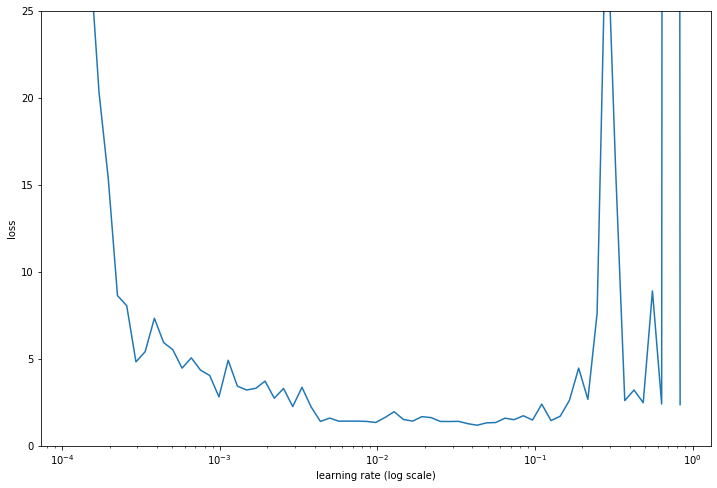

In [0]:
model = build_model()

model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

lr_finder = LRFinder(model)
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=100, batch_size=512, epochs=1)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1, y_lim=(0, 25))
plt.show()

In [0]:
model = build_model()

adam = keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_lr.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52480/52500 [============================>.] - ETA: 0s - loss: 9.8800 - sparse_categorical_accuracy: 0.4767
Epoch 00001: val_loss improved from inf to 1.23393, saving model to revnet_with_dense_lr.hdf5
52500/52500 [==============================] - 12s 238us/sample - loss: 9.8766 - sparse_categorical_accuracy: 0.4767 - val_loss: 1.2339 - val_sparse_categorical_accuracy: 0.6214
Epoch 2/40
52288/52500 [============================>.] - ETA: 0s - loss: 1.7716 - sparse_categorical_accuracy: 0.3961
Epoch 00002: val_loss did not improve from 1.23393
52500/52500 [==============================] - 11s 218us/sample - loss: 1.7735 - sparse_categorical_accuracy: 0.3956 - val_loss: 2.0485 - val_sparse_categorical_accuracy: 0.2289
Epoch 3/40
52288/52500 [============================>.] - ETA: 0s - loss: 2.2555 - sparse_categorical_accuracy: 0.1552
Epoch 00003: val_loss did not improve from 1.23393
52500/52500 [============================

In [0]:
model = build_model()

adam = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="revnet_with_dense_lr.hdf5", 
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=40, 
          validation_data=(X_test, y_test),
          callbacks=[checkpointer, earlystopper])

Train on 52500 samples, validate on 17500 samples
Epoch 1/40
52288/52500 [============================>.] - ETA: 0s - loss: 2.7939 - sparse_categorical_accuracy: 0.4979
Epoch 00001: val_loss improved from inf to 1.18438, saving model to revnet_with_dense_lr.hdf5
52500/52500 [==============================] - 13s 251us/sample - loss: 2.7865 - sparse_categorical_accuracy: 0.4986 - val_loss: 1.1844 - val_sparse_categorical_accuracy: 0.6418
Epoch 2/40
52416/52500 [============================>.] - ETA: 0s - loss: 0.9230 - sparse_categorical_accuracy: 0.7089
Epoch 00002: val_loss improved from 1.18438 to 0.65049, saving model to revnet_with_dense_lr.hdf5
52500/52500 [==============================] - 12s 222us/sample - loss: 0.9231 - sparse_categorical_accuracy: 0.7090 - val_loss: 0.6505 - val_sparse_categorical_accuracy: 0.7808
Epoch 3/40
52256/52500 [============================>.] - ETA: 0s - loss: 0.4861 - sparse_categorical_accuracy: 0.8548
Epoch 00003: val_loss improved from 0.65049 t

Лучше себя показало значение по умолчанию равное 0.001

**Среднее, дисперсия и максимальное значение выходов каждого слоя** (https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer):

In [0]:
def count_output_stats(model, data):
    inp = model.input                                         
    outputs = [layer.output for layer in model.layers]
    functors = [K.function([inp], [out]) for out in outputs]   

    layer_outs = np.array([func(data)[0] for func in functors])

    print("Layer_name     Mean      Std     AbsMax")
    for out, layer in zip(layer_outs, model.layers):
        print(layer.name, np.mean(out), np.std(out), np.max(np.abs(out)))

In [0]:
model = keras.models.load_model('revnet_with_dense.hdf5')
count_output_stats(model, X_train[:32])

Layer_name     Mean      Std     AbsMax
input_26 33.669403 78.76575 255.0
conv2d_125 0.34469685 3.6137059 25.740976
tf_op_layer_split_25 0.34469682 3.6137064 25.740976
batch_normalization_100 -0.040776733 1.0181673 3.634192
activation_147 0.3284836 0.7104299 3.634192
conv2d_126 -0.20385407 3.2157915 20.416842
batch_normalization_101 -0.18014385 1.0640172 5.8735495
activation_148 0.23189177 0.664201 5.593438
conv2d_127 -0.06973644 2.491622 19.98863
tf_op_layer_add_50 0.32768622 2.2203338 17.570183
batch_normalization_102 -0.147246 0.9671924 8.543778
activation_149 0.22942124 0.66501045 8.543778
conv2d_128 0.060606577 2.08692 17.628712
batch_normalization_103 -0.20750129 1.1196847 8.575382
activation_150 0.22977695 0.7793017 8.126232
conv2d_129 -0.10059774 3.0193844 30.934013
tf_op_layer_add_51 0.19137326 2.74274 25.824512
tf_op_layer_concat_25 0.2595297 2.496176 25.824512
flatten_25 0.2595297 2.496176 25.824512
dense_44 -149.66223 137.3638 826.3128
activation_151 3.0253463 26.151455 470

**Grad norms** (https://stackoverflow.com/questions/57759635/get-gradients-with-keras-tensorflow-2-0):

In [0]:
class GradientCallback(tf.keras.callbacks.Callback):

    def on_batch_end(self, batch, logs=None):
        loss = self.model.total_loss
        optimizer = self.model.optimizer
        gradients = optimizer.get_gradients(loss, self.model.trainable_weights)
        for t in gradients:
            print('Tensor: {}'.format(t.name))
            print('{}\n'.format(t.numpy()[:10]))

Данный код кидает ошибку:

In [90]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

gradient_callback = GradientCallback()

model.fit(X_train, y_train,
          batch_size=32, epochs=1, 
          validation_data=(X_test, y_test),
          callbacks=[gradient_callback])

Train on 52500 samples, validate on 17500 samples
Tensor: Adam/gradients_39/gradients/conv2d_161/Conv2D_grad/Conv2DBackpropFilter:0
    0/52500 [..............................] - ETA: 0s

AttributeError: ignored

**Свой training loop** (https://www.tensorflow.org/guide/keras/train_and_evaluate):

In [0]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [96]:
model = build_model()

optimizer = keras.optimizers.Adam()
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

epochs = 3
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape() as tape:

      # Run the forward pass of the layer.
      # The operations that the layer applies
      # to its inputs are going to be recorded
      # on the GradientTape.
      logits = model(x_batch_train, training=True)  # Logits for this minibatch

      # Compute the loss value for this minibatch.
      loss_value = loss_fn(y_batch_train, logits)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Log every 200 batches.
    if step % 200 == 0:
        print(logits)
        print(y_batch_train)
        print(train_acc_metric(y_batch_train, logits))
        print([tf.norm(grad).numpy() for grad in grads])
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

  train_acc = train_acc_metric.result()
  print('Training acc over epoch: %s' % (float(train_acc),))

Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0002707e-06 6.7088198e-36 4.2565485e-15
  0.0000000e+00 9.9999905e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 2.9756083e-26 1.5139476e-26 0.0000000e+00 3.6670054e-19
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0

KeyboardInterrupt: ignored

Непонятно почему вырождается в константную модель, хотя вроде с теми же оптимизаторами и функциями потерь обычный fit работает нормально:

In [85]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X_train, y_train,
          batch_size=32, epochs=1, 
          validation_data=(X_test, y_test))

Train on 52500 samples, validate on 17500 samples
52500/52500 [==============================] - 13s 255us/sample - loss: 2.5533 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.6652 - val_sparse_categorical_accuracy: 0.8377


**Модель с Reversible блоком, где в конце выбирается 10 чисел из равномерной сетки:**

In [0]:
input_shape = X_train.shape[1:]
filters = 32
n_rev_blocks = 1
n_classes = 10

def build_model():
    img_input = L.Input(input_shape)
    x = init_block(img_input, filters)
    for _ in range(n_rev_blocks):
        x = rev_block(x, filters)
    x = L.Flatten()(x)

    positions = tf.range(0, x.shape[-1], x.shape[-1] // n_classes + 1)
    x = tf.reshape(tf.convert_to_tensor([x[:, i] for i in positions]), (-1, n_classes))
    x = L.Activation("softmax")(x)

    model = keras.Model(img_input, x)
    return model

In [16]:
model = build_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 28, 28, 32)   128         input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split_3 (TensorFlow [(None, 28, 28, 16), 0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 28, 28, 16)   64          tf_op_layer_split_3[0][1]        
____________________________________________________________________________________________

**Переобучение модели на маленьком батче:**

In [0]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X_train[:32], y_train[:32],
          batch_size=32, epochs=40,)

Train on 32 samples
Epoch 1/40
32/32 [==============================] - 1s 31ms/sample - loss: 36.3624 - sparse_categorical_accuracy: 0.0938
Epoch 2/40
32/32 [==============================] - 0s 402us/sample - loss: 35.5335 - sparse_categorical_accuracy: 0.0625
Epoch 3/40
32/32 [==============================] - 0s 351us/sample - loss: 34.6310 - sparse_categorical_accuracy: 0.1562
Epoch 4/40
32/32 [==============================] - 0s 382us/sample - loss: 30.1114 - sparse_categorical_accuracy: 0.1250
Epoch 5/40
32/32 [==============================] - 0s 356us/sample - loss: 26.2750 - sparse_categorical_accuracy: 0.2812
Epoch 6/40
32/32 [==============================] - 0s 346us/sample - loss: 26.6770 - sparse_categorical_accuracy: 0.0938
Epoch 7/40
32/32 [==============================] - 0s 326us/sample - loss: 15.6507 - sparse_categorical_accuracy: 0.0312
Epoch 8/40
32/32 [==============================] - 0s 313us/sample - loss: 29.8816 - sparse_categorical_accuracy: 0.0625
Epoch

**На всех данных:**

In [0]:
model = build_model()

adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X_train, y_train,
          batch_size=32, epochs=8, 
          validation_data=(X_test, y_test))

Train on 52500 samples, validate on 17500 samples
Epoch 1/8
52500/52500 [==============================] - 13s 239us/sample - loss: 2.8786 - sparse_categorical_accuracy: 0.1002 - val_loss: 2.3615 - val_sparse_categorical_accuracy: 0.1015
Epoch 2/8
52500/52500 [==============================] - 11s 219us/sample - loss: 2.3411 - sparse_categorical_accuracy: 0.0995 - val_loss: 2.3501 - val_sparse_categorical_accuracy: 0.1008
Epoch 3/8
52500/52500 [==============================] - 11s 219us/sample - loss: 2.3390 - sparse_categorical_accuracy: 0.0984 - val_loss: 2.3363 - val_sparse_categorical_accuracy: 0.1019
Epoch 4/8
52500/52500 [==============================] - 12s 221us/sample - loss: 2.3364 - sparse_categorical_accuracy: 0.1010 - val_loss: 2.3389 - val_sparse_categorical_accuracy: 0.1045
Epoch 5/8
52500/52500 [==============================] - 11s 219us/sample - loss: 2.3341 - sparse_categorical_accuracy: 0.1025 - val_loss: 2.3348 - val_sparse_categorical_accuracy: 0.1013
Epoch 6/8


**LR range test:**

Train on 52500 samples
41472/52500 [======================>.......] - ETA: 1s - loss: 472.2243 - sparse_categorical_accuracy: 0.0996

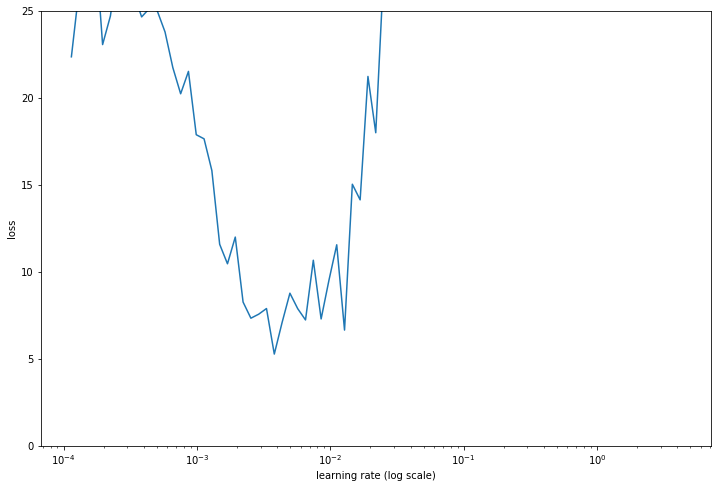

In [0]:
model = build_model()

model.compile(optimizer=keras.optimizers.SGD(),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

lr_finder = LRFinder(model)
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=100, batch_size=512, epochs=1)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1, y_lim=(0, 25))
plt.show()

In [0]:
model = build_model()

model.compile(optimizer=keras.optimizers.SGD(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X_train, y_train,
          batch_size=32, epochs=8, 
          validation_data=(X_test, y_test))

Train on 52500 samples, validate on 17500 samples
Epoch 1/8
52500/52500 [==============================] - 12s 230us/sample - loss: 3.4716 - sparse_categorical_accuracy: 0.1003 - val_loss: 3.8311 - val_sparse_categorical_accuracy: 0.0994
Epoch 2/8
52500/52500 [==============================] - 11s 211us/sample - loss: 3.2511 - sparse_categorical_accuracy: 0.0980 - val_loss: 4.5026 - val_sparse_categorical_accuracy: 0.0989
Epoch 3/8
52500/52500 [==============================] - 11s 210us/sample - loss: 3.2418 - sparse_categorical_accuracy: 0.0996 - val_loss: 3.2410 - val_sparse_categorical_accuracy: 0.0984
Epoch 4/8
52500/52500 [==============================] - 11s 210us/sample - loss: 3.1874 - sparse_categorical_accuracy: 0.1004 - val_loss: 3.8680 - val_sparse_categorical_accuracy: 0.0993
Epoch 5/8
52500/52500 [==============================] - 11s 210us/sample - loss: 3.2906 - sparse_categorical_accuracy: 0.1005 - val_loss: 2.6657 - val_sparse_categorical_accuracy: 0.0997
Epoch 6/8


**Статистики:**

In [0]:
count_output_stats(model, X_train[:32])

Layer_name     Mean      Std     AbsMax
input_29 33.669403 78.76575 255.0
conv2d_140 4.231854 29.188667 210.1025
tf_op_layer_split_28 4.231854 29.188667 210.1025
batch_normalization_112 -0.060708497 1.01179 4.95125
activation_163 0.28781343 0.6900325 2.853308
conv2d_141 -0.15365316 0.9361949 5.795438
batch_normalization_113 -0.1363029 0.9564958 5.326945
activation_164 0.2682067 0.480782 4.5242367
conv2d_142 0.050192434 0.49655452 4.2259264
tf_op_layer_add_56 3.7044044 27.961082 196.4603
batch_normalization_114 0.013626135 0.9481851 3.6829545
activation_165 0.32152814 0.66628516 3.3332853
conv2d_143 0.06382023 0.87668425 5.9434075
batch_normalization_115 -0.0071410853 0.93496156 5.801188
activation_166 0.32338476 0.619174 5.801188
conv2d_144 -0.053391617 0.6353927 4.3104606
tf_op_layer_add_57 4.756104 30.14578 209.5515
tf_op_layer_concat_28 4.2302537 29.078714 209.5515
flatten_28 4.2302537 29.078714 209.5515
tf_op_layer_strided_slice_50 0.0699166 0.0 0.0699166
tf_op_layer_strided_slice_

В данной моделе видно, что она не может обучиться даже на маленьком батче, нужно исправлять модель.